In [13]:
from google.colab import drive
import os
from sklearn.model_selection import train_test_split
import numpy as np
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
from glob import glob
import cv2 
import time
import datetime
from tqdm import tqdm
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import pandas as pd 
import random
from subprocess import check_output
from keras.utils import to_categorical

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.environ['KAGGLE_USERNAME'] = "mohamedrashad556" # username from the json file
os.environ['KAGGLE_KEY'] = "db7189344e0f1e2261828a2da3d1fb73" # key from the json file
!kaggle competitions download -c diabetic-retinopathy-detection -f train.zip.003
!kaggle competitions download -c diabetic-retinopathy-detection -f trainLabels.csv.zip
! unzip "trainLabels.csv.zip"
! unzip "train.zip.003.zip"
!apt install p7zip-full -y
!7z x train.zip.003 #extract
!ls train | wc -l #print number of images
!ls train #print paths

In [6]:
base_image_dir = "/content/train"
retina_df = pd.read_csv("/content/trainLabels.csv")
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir,
                                                         '{}.jpeg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(10)

8482 images found of 35126 total


,image,level,PatientId,path,exists,eye,level_cat
25833,32689_right,0,32689,/content/train/32689_right.jpeg,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
2808,3485_left,2,3485,/content/train/3485_left.jpeg,True,1,"[0.0, 0.0, 1.0, 0.0, 0.0]"
25023,31670_right,0,31670,/content/train/31670_right.jpeg,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
29303,37097_right,1,37097,/content/train/37097_right.jpeg,True,0,"[0.0, 1.0, 0.0, 0.0, 0.0]"
27591,34928_right,0,34928,/content/train/34928_right.jpeg,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
29176,36939_left,0,36939,/content/train/36939_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
28164,35667_left,2,35667,/content/train/35667_left.jpeg,True,1,"[0.0, 0.0, 1.0, 0.0, 0.0]"
30324,38356_left,0,38356,/content/train/38356_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
24265,30660_right,0,30660,/content/train/30660_right.jpeg,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
24542,31011_left,0,31011,/content/train/31011_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"


New Data Size: 5000 Old Size: 8482


,PatientId,exists,eye,image,level_cat,path
level,,,,,,
0,1000,1000,1000,1000,1000,1000
1,1000,1000,1000,1000,1000,1000
2,1000,1000,1000,1000,1000,1000
3,1000,1000,1000,1000,1000,1000
4,1000,1000,1000,1000,1000,1000


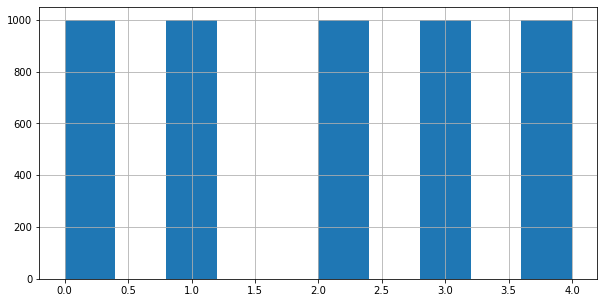

In [7]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df
train_df = balance_data(1000,retina_df) # oversample such that all classes have the same number of images as the maximum
retina_df.pivot_table(index='level', aggfunc=len)
train_df.pivot_table(index='level', aggfunc=len)


In [8]:
def get_label_and_image(path): 
  name= path.split('/')[-1].split('.')[0]
  label=train_df["level_cat"].loc[train_df['image'] == name].values[0]
  image=plt.imread(path)
  return image,label #returns (L, W, 3) np array (RGB) and Int Label

In [ ]:
IMAGE_SIZE=(299,299)
dataset={"image":[],
            "label":[]}
paths=train_df["path"]
for counter in range(len(paths)):
  image,label=get_label_and_image(paths[counter])
  dataset["image"].append(cv2.resize(image, IMAGE_SIZE))
  dataset["label"].append(label)
  print(f"{counter}/{len(paths)}")

In [10]:
train_images, test_images, train_labels, test_labels = train_test_split(np.asarray(dataset["image"]), np.asarray(dataset["label"]), test_size=0.2, random_state=42)#,stratify=np.asarray(dataset["label"]))
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)#,stratify=test_labels)
print(train_images.shape,train_labels.shape)
print(val_images.shape,val_labels.shape)
print(test_images.shape,test_labels.shape)
print(np.unique(train_labels.argmax(1),return_counts=True))
print(np.unique(val_labels.argmax(1),return_counts=True))
print(np.unique(test_labels.argmax(1),return_counts=True))

(4000, 299, 299, 3) (4000, 5)
(500, 299, 299, 3) (500, 5)
(500, 299, 299, 3) (500, 5)
(array([0, 1, 2, 3, 4]), array([798, 821, 803, 791, 787]))
(array([0, 1, 2, 3, 4]), array([112,  83,  91, 110, 104]))
(array([0, 1, 2, 3, 4]), array([ 90,  96, 106,  99, 109]))


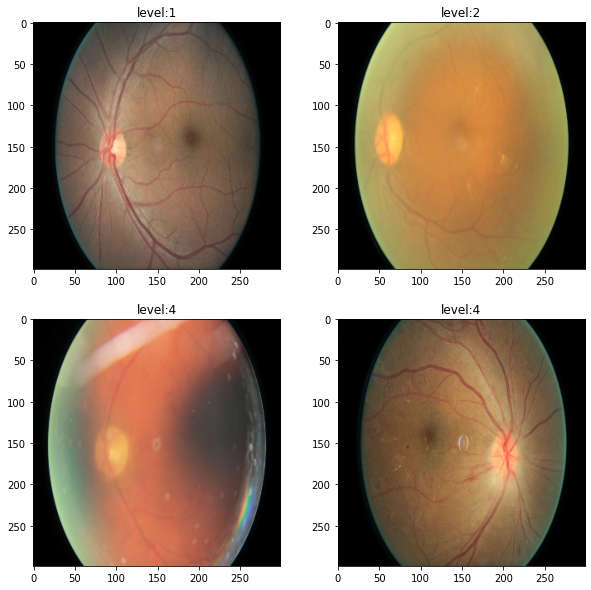

In [11]:
#data visualization
f, axarr = plt.subplots(2,2, figsize=(10, 10))
randidx=[np.random.randint(0,train_images.shape[0]) for i in range (4)]

axarr[0,0].imshow(train_images[randidx[0]])
axarr[0,0].set_title("level:"+ str(train_labels[randidx[0]].argmax(0)));  

axarr[0,1].imshow(train_images[randidx[1]])
axarr[0,1].set_title("level:"+ str(train_labels[randidx[1]].argmax(0))); 

axarr[1,0].imshow(train_images[randidx[2]])
axarr[1,0].set_title("level:"+ str(train_labels[randidx[2]].argmax(0)));  

axarr[1,1].imshow(train_images[randidx[3]])
axarr[1,1].set_title("level:"+ str(train_labels[randidx[3]].argmax(0)));  

In [23]:
EPOCHS = 30
INIT_LR = 1e-3
def createModel():
    model = Sequential()
    # first set of CONV => RELU => MAX POOL layers
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=IMAGE_SIZE+(3,)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    # returns our fully constructed deep learning + Keras image classifier 
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    # use binary_crossentropy if there are two classes
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model


In [24]:
model = createModel()

In [25]:
history=model.fit(
        x=train_images,
        y=train_labels,
        validation_data = (val_images,val_labels),
        epochs = EPOCHS,
        shuffle=True,
        batch_size=10
)

Epoch 1/30
400/400 [==============================] - 42s 76ms/step - loss: 4.7310 - accuracy: 0.2327 - val_loss: 1.5916 - val_accuracy: 0.2560
Epoch 2/30
400/400 [==============================] - 31s 77ms/step - loss: 1.5801 - accuracy: 0.2763 - val_loss: 1.5649 - val_accuracy: 0.2880
Epoch 3/30
400/400 [==============================] - 31s 78ms/step - loss: 1.5517 - accuracy: 0.2928 - val_loss: 1.5428 - val_accuracy: 0.2800
Epoch 4/30
400/400 [==============================] - 31s 78ms/step - loss: 1.5300 - accuracy: 0.3155 - val_loss: 1.5331 - val_accuracy: 0.2860
Epoch 5/30
400/400 [==============================] - 31s 78ms/step - loss: 1.5053 - accuracy: 0.3228 - val_loss: 1.5128 - val_accuracy: 0.2980
Epoch 6/30
400/400 [==============================] - 31s 78ms/step - loss: 1.4840 - accuracy: 0.3553 - val_loss: 1.4876 - val_accuracy: 0.3340
Epoch 7/30
400/400 [==============================] - 31s 78ms/step - loss: 1.4610 - accuracy: 0.3535 - val_loss: 1.4677 - val_accuracy:

In [ ]:
model.optimizer._decayed_lr(tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=0.001>

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


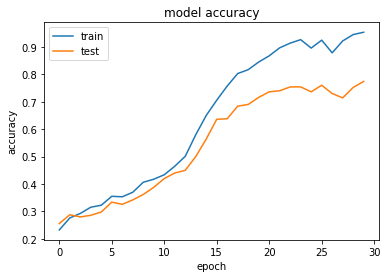

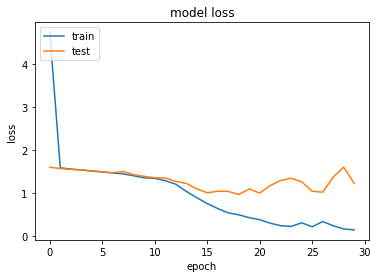

In [26]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
model.save_weights("/content/drive/MyDrive/CNN_Model/Weights")

In [29]:
model.evaluate(test_images,test_labels)

16/16 [==============================] - 3s 131ms/step - loss: 1.2299 - accuracy: 0.7840


[1.2298654317855835, 0.7839999794960022]